In [1]:
# pip install pytorch_lightning

In [2]:
# pip install spacy

In [3]:
# !python -m spacy download ru_core_news_lg

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

from tqdm import tqdm
from sklearn.model_selection import GroupKFold

import pytorch_lightning as pl

import utils

%load_ext autoreload
%autoreload 1
%aimport utils

In [5]:
data_folder = '../data/'

In [6]:
df = utils.read_preprocessed_financial_data(data_folder, enc_cols=['mcc_description', 'tr_description'])
df.shape 

(3751083, 10)

In [7]:
df.head()

,customer_id,tr_datetime,mcc_code,tr_type,amount,term_id,gender,mcc_description,tr_description,week
0,39026145.0,0,4814.0,1030,-2245.92,311690,1.0,"[-0.102810316, -0.12563597, -0.11075681, -0.06...","[0.07799721, 0.21862344, 0.1882922, -0.1851609...",0
1,39026145.0,13328582400,4814.0,1030,-5614.79,311690,1.0,"[-0.102810316, -0.12563597, -0.11075681, -0.06...","[0.07799721, 0.21862344, 0.1882922, -0.1851609...",0
2,39026145.0,17673984000,4814.0,1030,-1122.96,311690,1.0,"[-0.102810316, -0.12563597, -0.11075681, -0.06...","[0.07799721, 0.21862344, 0.1882922, -0.1851609...",1
3,39026145.0,30168547200,4814.0,1030,-2245.92,311690,1.0,"[-0.102810316, -0.12563597, -0.11075681, -0.06...","[0.07799721, 0.21862344, 0.1882922, -0.1851609...",1
4,39026145.0,48592051200,4814.0,1030,-2245.92,311690,1.0,"[-0.102810316, -0.12563597, -0.11075681, -0.06...","[0.07799721, 0.21862344, 0.1882922, -0.1851609...",1


In [8]:
clients = df['customer_id'].unique()
clients = clients[:100] # drop this row (I just tested the code with small amount of data)

df_week = []

for client_id in tqdm(clients):
    client_data = df[df['customer_id'] == client_id]
    client_weeks = client_data.week.unique()
    
    for week in client_weeks:
        client_data_week = client_data[client_data['week'] == week]
        df_week.append(
            {
                'transactions': client_data_week['mcc_code'].tolist(),
                'amounts': client_data_week['amount'].tolist(),
                'tr_datetime': client_data_week['tr_datetime'].tolist(),
                'tr_type': client_data_week['tr_type'].tolist(),
                'mcc_description': client_data_week['mcc_description'].tolist(), # add mcc_description embeddings
                'tr_description': client_data_week['tr_description'].tolist(), # add tr_description embeddings
                'term_id': client_data_week['term_id'].tolist(),
                'customer_id': client_id, 
                'week': week,
                'gender': client_data_week['gender'].tolist()
            }
        )

100%|██████████| 100/100 [00:06<00:00, 15.24it/s]


In [9]:
df_week = pd.DataFrame(df_week)
df_week.shape

(5990, 10)

In [10]:
df_week.head(3)

,transactions,amounts,tr_datetime,tr_type,mcc_description,tr_description,term_id,customer_id,week,gender
0,"[4814.0, 4814.0, 5499.0, 5499.0, 5499.0, 5499....","[-2245.92, -5614.79, -1392.47, -920.83, -1010....","[0, 13328582400, 3317241600, 9680601600, 14449...","[1030, 1030, 1010, 1010, 1010, 1010, 1010, 101...","[[-0.102810316, -0.12563597, -0.11075681, -0.0...","[[0.07799721, 0.21862344, 0.1882922, -0.185160...","[311690, 311690, 311690, 311690, 311690, 31169...",39026145.0,0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
1,"[4814.0, 4814.0, 4814.0, 4814.0, 4814.0, 5499....","[-1122.96, -2245.92, -2245.92, -2245.92, -2245...","[17673984000, 30168547200, 48592051200, 487840...","[1030, 1030, 1030, 1030, 1030, 1010, 1010, 101...","[[-0.102810316, -0.12563597, -0.11075681, -0.0...","[[0.07799721, 0.21862344, 0.1882922, -0.185160...","[311690, 311690, 311690, 311690, 311690, 31169...",39026145.0,1,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
2,"[4814.0, 4814.0, 4814.0, 5331.0, 5331.0, 5331....","[-2245.92, -449.18, -1122.96, -6288.56, -1122....","[42837984000, 79248240000, 79340169600, 0, 0, ...","[1030, 1030, 1030, 1110, 1110, 1110, 1110, 101...","[[-0.102810316, -0.12563597, -0.11075681, -0.0...","[[0.07799721, 0.21862344, 0.1882922, -0.185160...","[311690, 311690, 311690, 311690, 311690, 31169...",39026145.0,2,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


In [11]:
MIN_LEN = 20
MAX_LEN = 50

lens = df_week.transactions.apply(lambda x: len(x))
df_week = df_week[(lens >= MIN_LEN) & (lens <= MAX_LEN)]
df_week.shape

(598, 10)

In [12]:
features = ['transactions', 'amounts', 'tr_datetime', 'tr_type', 'term_id', 'mcc_description'] #, 'tr_description'] 
desc_cols = ['mcc_description', 'tr_description']

INPUT_SIZE = len(list(set(features) - set(desc_cols)))
if 'mcc_description' in features:
    INPUT_SIZE += len(df['mcc_description'].iloc[0])
if 'tr_description' in features:
    INPUT_SIZE += len(df['tr_description'].iloc[0])
    
EPOCHS = 100
N_SPLITS = 5

In [13]:
INPUT_SIZE

305

# GRU

In [14]:
base_model = utils.RNN(
    input_size=INPUT_SIZE,
    output_size=1,
    hidden_rnn_size=16,
    base_type="GRU"
)

/home/sequential_data/transformers_for_financial_data/experiments/utils.py:102: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  torch.tensor(df1[col].iloc[i]) for col in desc_cols_feat
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Missing logger folder: ../logs/GRU_100_12232021_07:54:30

  | Name          | Type    | Params
------------------------------------------
0 | model         | RNN     | 15.5 K
1 | loss_function | BCELoss | 0     
------------------------------------------
15.5 K    Trainable params
0         Non-trainable params
15.5 K    Total params
0.062     Total estimated model params size (MB)


Epoch 0:   0%|          | 0/4 [00:00<?, ?it/s]                        

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:413: UserWarning: The number of training samples (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the logging interval"


Epoch 0:  50%|█████     | 2/4 [00:00<00:00,  2.26it/s, loss=0.867, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1:  50%|█████     | 2/4 [00:00<00:00,  2.30it/s, loss=0.859, v_num=0, val_loss=0.783, val_acc=0.426, mean_accuracy=0.426, mean_roc_auc=0.187, mean_pr_auc=0.564, train_loss=0.869, train_acc=0.000]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|█████     | 2/4 [00:00<00:00,  2.27it/s, loss=0.854, v_num=0, val_loss=0.776, val_acc=0.447, mean_accuracy=0.447, mean_roc_auc=0.280, mean_pr_auc=0.625, train_loss=0.856, train_acc=0.000]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|█████     | 2/4 [00:00<00:00,  2.18it/s, loss=0.849, v_num=0, val_loss=0.769, val_acc=0.489, mean_accuracy=0.489, mean_roc_auc=0.298, mean_pr_auc=0.645, train_loss=0.843, train_acc=0.000]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|█████     | 2/4 [00:00<00:00,  2.13it/s, loss=0.842, v_num=0, val_loss=0.762, val_acc=0.489, mean_accuracy=0.489, mean_roc_auc=0.335, mean_pr_auc=0.671, train_loss=0.829, train_acc

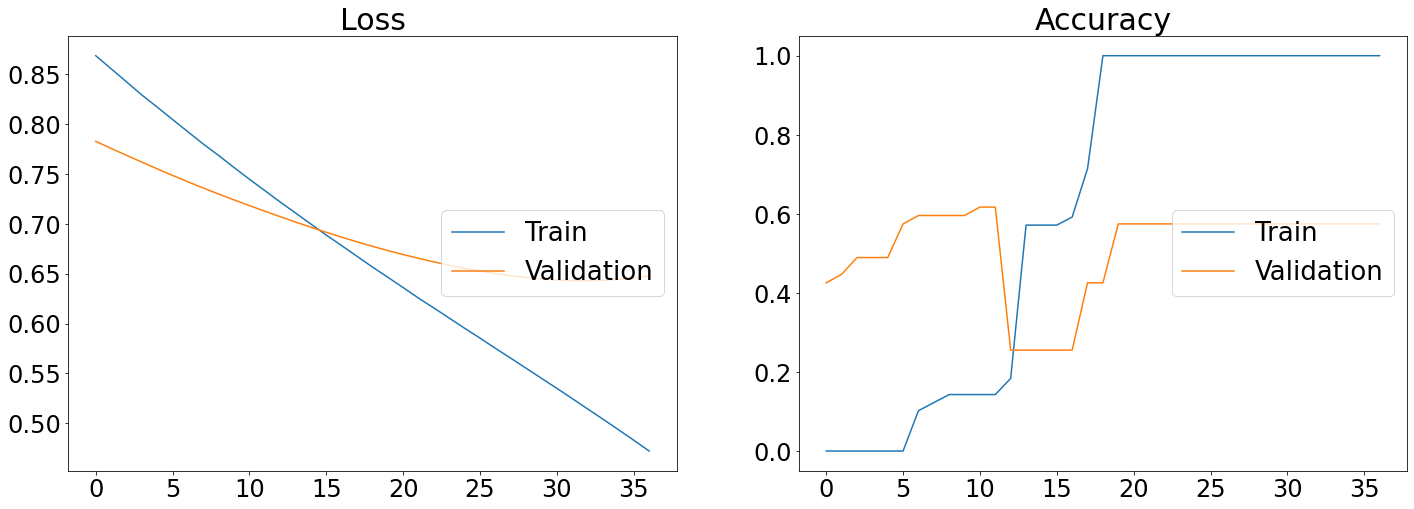

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Missing logger folder: ../logs/GRU_100_12232021_07:58:22

  | Name          | Type    | Params
------------------------------------------
0 | model         | RNN     | 15.5 K
1 | loss_function | BCELoss | 0     
------------------------------------------
15.5 K    Trainable params
0         Non-trainable params
15.5 K    Total params
0.062     Total estimated model params size (MB)


Epoch 0:   0%|          | 0/4 [00:00<?, ?it/s]                        

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:413: UserWarning: The number of training samples (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the logging interval"


Epoch 0:  50%|█████     | 2/4 [00:01<00:01,  1.89it/s, loss=0.499, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1:  50%|█████     | 2/4 [00:01<00:01,  2.00it/s, loss=0.499, v_num=0, val_loss=0.922, val_acc=0.233, mean_accuracy=0.233, mean_roc_auc=0.0121, mean_pr_auc=0.183, train_loss=0.497, train_acc=0.960]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|█████     | 2/4 [00:00<00:00,  2.02it/s, loss=0.49, v_num=0, val_loss=0.933, val_acc=0.233, mean_accuracy=0.233, mean_roc_auc=0.0121, mean_pr_auc=0.183, train_loss=0.488, train_acc=0.960] 
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|█████     | 2/4 [00:01<00:01,  1.93it/s, loss=0.486, v_num=0, val_loss=0.944, val_acc=0.233, mean_accuracy=0.233, mean_roc_auc=0.00606, mean_pr_auc=0.183, train_loss=0.478, train_acc=0.960]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|█████     | 2/4 [00:01<00:01,  1.95it/s, loss=0.479, v_num=0, val_loss=0.956, val_acc=0.233, mean_accuracy=0.233, mean_roc_auc=0.0121, mean_pr_auc=0.183, train_loss=0.469, trai

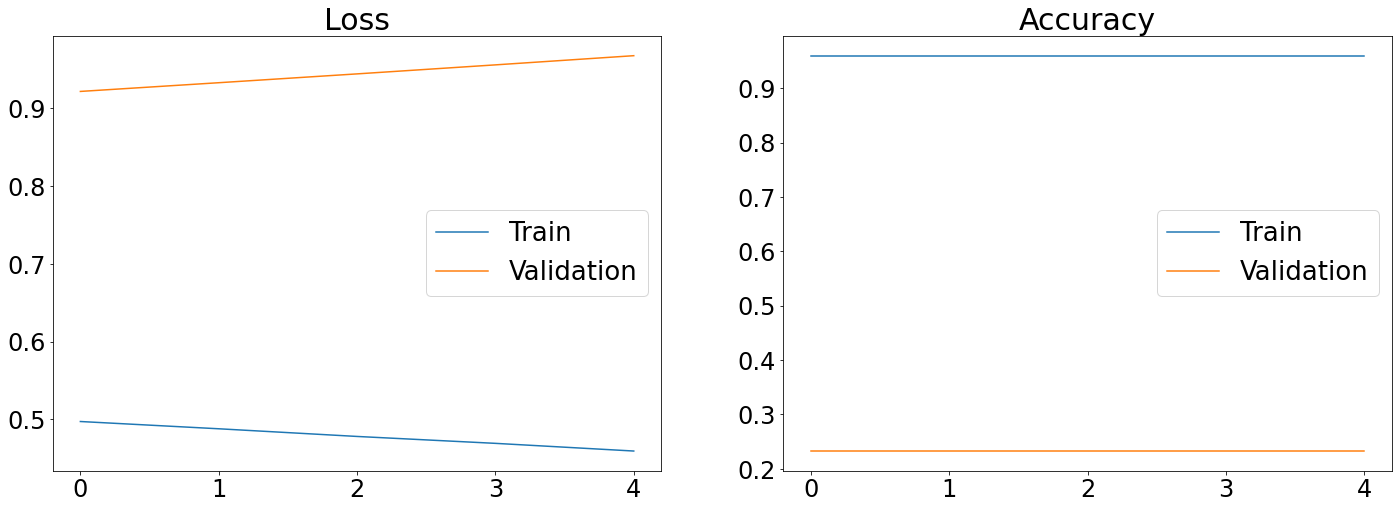

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Missing logger folder: ../logs/GRU_100_12232021_07:58:44

  | Name          | Type    | Params
------------------------------------------
0 | model         | RNN     | 15.5 K
1 | loss_function | BCELoss | 0     
------------------------------------------
15.5 K    Trainable params
0         Non-trainable params
15.5 K    Total params
0.062     Total estimated model params size (MB)


Epoch 0:   0%|          | 0/4 [00:00<?, ?it/s]                        

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:413: UserWarning: The number of training samples (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the logging interval"


Epoch 0:  50%|█████     | 2/4 [00:01<00:01,  1.85it/s, loss=0.441, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1:  50%|█████     | 2/4 [00:01<00:01,  1.92it/s, loss=0.443, v_num=0, val_loss=0.977, val_acc=0.233, mean_accuracy=0.233, mean_roc_auc=0.000, mean_pr_auc=0.182, train_loss=0.448, train_acc=0.940]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|█████     | 2/4 [00:01<00:01,  1.54it/s, loss=0.441, v_num=0, val_loss=0.990, val_acc=0.233, mean_accuracy=0.233, mean_roc_auc=0.0152, mean_pr_auc=0.182, train_loss=0.440, train_acc=0.940]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|█████     | 2/4 [00:00<00:00,  2.08it/s, loss=0.434, v_num=0, val_loss=1.000, val_acc=0.233, mean_accuracy=0.233, mean_roc_auc=0.0152, mean_pr_auc=0.182, train_loss=0.432, train_acc=0.940]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|█████     | 2/4 [00:00<00:00,  2.07it/s, loss=0.43, v_num=0, val_loss=1.020, val_acc=0.233, mean_accuracy=0.233, mean_roc_auc=0.000, mean_pr_auc=0.182, train_loss=0.423, train_ac

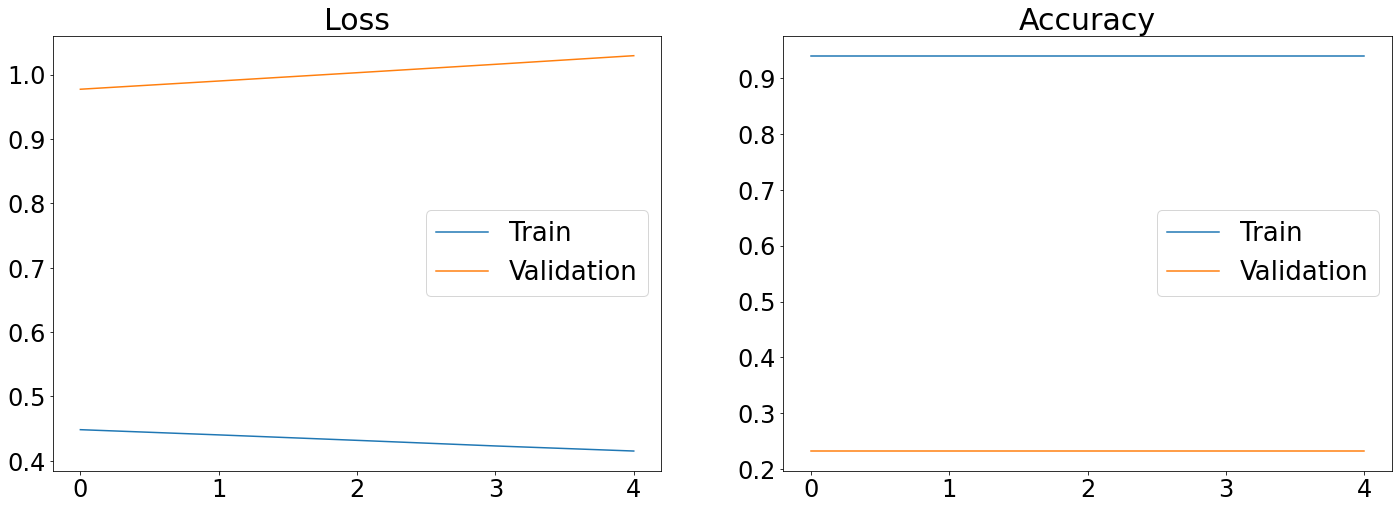

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Missing logger folder: ../logs/GRU_100_12232021_07:58:59

  | Name          | Type    | Params
------------------------------------------
0 | model         | RNN     | 15.5 K
1 | loss_function | BCELoss | 0     
------------------------------------------
15.5 K    Trainable params
0         Non-trainable params
15.5 K    Total params
0.062     Total estimated model params size (MB)


Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:686: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


DirectoryDeletedError: Directory ../logs/GRU_100_12232021_07:58:59/version_0 has been permanently deleted

In [15]:
metrics_gru = utils.cross_validation(df_week, "GRU", base_model, features, n_splits=N_SPLITS, epochs=EPOCHS, gpus=[1])
metrics_gru

In [ ]:
for metric_name, metric_val in metrics_gru.items():
    print('{}: {} ± {}'.format(metric_name, np.array(metric_val).mean(), np.array(metric_val).std()))

# LSTM

In [17]:
base_model = utils.RNN(
    input_size=INPUT_SIZE,
    output_size=1,
    hidden_rnn_size=16,
    base_type="LSTM"
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Missing logger folder: ../logs/LSTM_100_12232021_06:35:34

  | Name          | Type    | Params
------------------------------------------
0 | model         | RNN     | 20.7 K
1 | loss_function | BCELoss | 0     
------------------------------------------
20.7 K    Trainable params
0         Non-trainable params
20.7 K    Total params
0.083     Total estimated model params size (MB)


Epoch 0:   0%|          | 0/4 [00:00<?, ?it/s]                        

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:413: UserWarning: The number of training samples (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the logging interval"


Epoch 0:  50%|█████     | 2/4 [00:01<00:01,  1.46it/s, loss=0.786, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1:  50%|█████     | 2/4 [00:01<00:01,  1.56it/s, loss=0.783, v_num=0, val_loss=0.795, val_acc=0.106, mean_accuracy=0.106, mean_roc_auc=0.00185, mean_pr_auc=0.437, train_loss=0.792, train_acc=0.429]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|█████     | 2/4 [00:01<00:01,  1.55it/s, loss=0.782, v_num=0, val_loss=0.795, val_acc=0.106, mean_accuracy=0.106, mean_roc_auc=0.00185, mean_pr_auc=0.437, train_loss=0.786, train_acc=0.429]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|█████     | 2/4 [00:01<00:01,  1.59it/s, loss=0.781, v_num=0, val_loss=0.794, val_acc=0.106, mean_accuracy=0.106, mean_roc_auc=0.00185, mean_pr_auc=0.437, train_loss=0.780, train_acc=0.429]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|█████     | 2/4 [00:01<00:01,  1.54it/s, loss=0.78, v_num=0, val_loss=0.793, val_acc=0.106, mean_accuracy=0.106, mean_roc_auc=0.00185, mean_pr_auc=0.437, train_loss=0.774, tr

Exception ignored in: <function _ConnectionBase.__del__ at 0x7feb56517440>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 132, in __del__
    self._close()
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


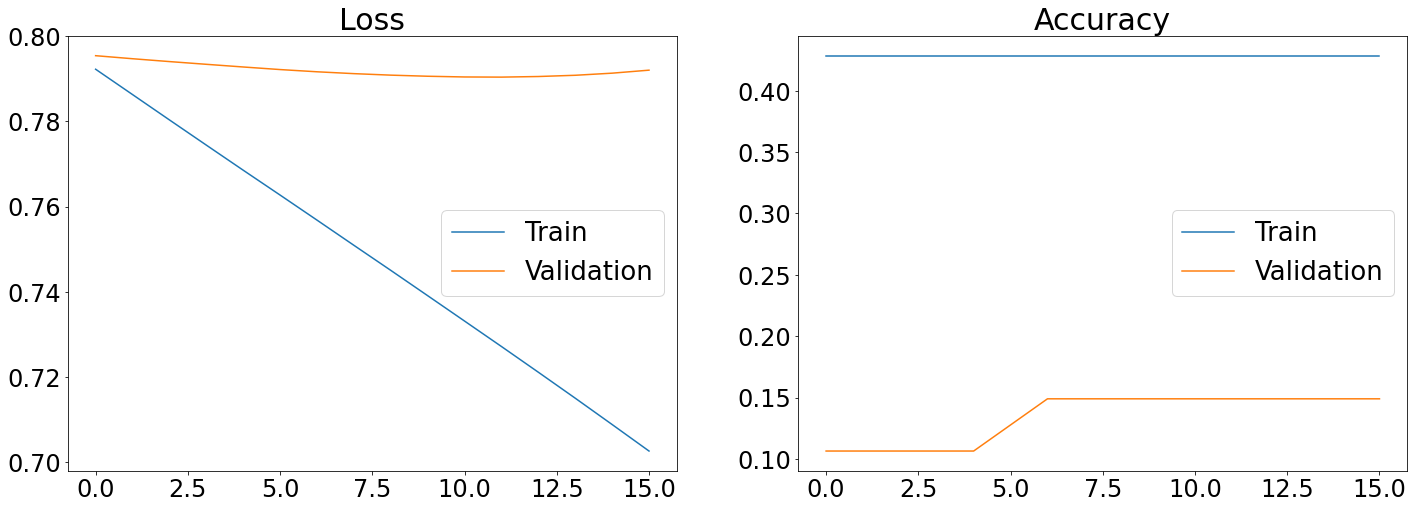

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Missing logger folder: ../logs/LSTM_100_12232021_06:38:17

  | Name          | Type    | Params
------------------------------------------
0 | model         | RNN     | 20.7 K
1 | loss_function | BCELoss | 0     
------------------------------------------
20.7 K    Trainable params
0         Non-trainable params
20.7 K    Total params
0.083     Total estimated model params size (MB)


Epoch 0:   0%|          | 0/4 [00:00<?, ?it/s]                        

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:413: UserWarning: The number of training samples (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the logging interval"


Epoch 0:  50%|█████     | 2/4 [00:01<00:01,  1.51it/s, loss=0.673, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1:  50%|█████     | 2/4 [00:01<00:01,  1.49it/s, loss=0.67, v_num=0, val_loss=0.661, val_acc=0.698, mean_accuracy=0.698, mean_roc_auc=0.988, mean_pr_auc=0.933, train_loss=0.674, train_acc=0.520] 
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|█████     | 2/4 [00:01<00:01,  1.57it/s, loss=0.667, v_num=0, val_loss=0.664, val_acc=0.698, mean_accuracy=0.698, mean_roc_auc=0.988, mean_pr_auc=0.933, train_loss=0.669, train_acc=0.520]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|█████     | 2/4 [00:01<00:01,  1.49it/s, loss=0.666, v_num=0, val_loss=0.668, val_acc=0.698, mean_accuracy=0.698, mean_roc_auc=0.988, mean_pr_auc=0.933, train_loss=0.664, train_acc=0.520]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|█████     | 2/4 [00:01<00:01,  1.50it/s, loss=0.664, v_num=0, val_loss=0.671, val_acc=0.698, mean_accuracy=0.698, mean_roc_auc=0.988, mean_pr_auc=0.933, train_loss=0.658, train_acc

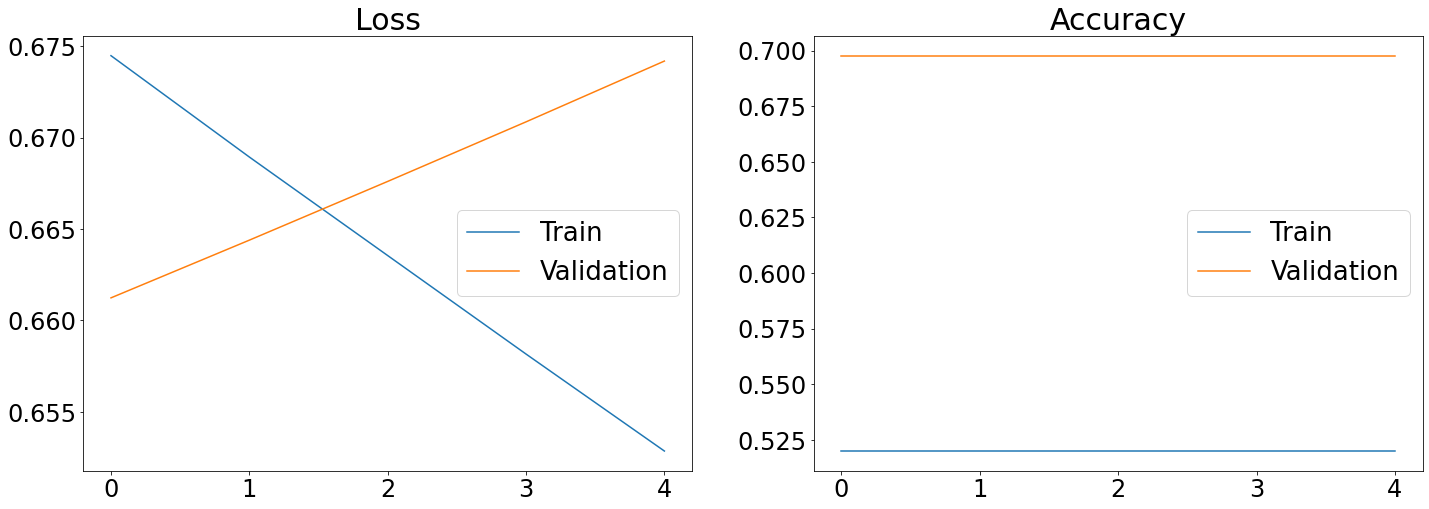

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Missing logger folder: ../logs/LSTM_100_12232021_06:39:08

  | Name          | Type    | Params
------------------------------------------
0 | model         | RNN     | 20.7 K
1 | loss_function | BCELoss | 0     
------------------------------------------
20.7 K    Trainable params
0         Non-trainable params
20.7 K    Total params
0.083     Total estimated model params size (MB)


Epoch 0:   0%|          | 0/4 [00:00<?, ?it/s]                        

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:413: UserWarning: The number of training samples (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the logging interval"


Epoch 0:  50%|█████     | 2/4 [00:01<00:01,  1.46it/s, loss=0.679, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1:  50%|█████     | 2/4 [00:01<00:01,  1.50it/s, loss=0.676, v_num=0, val_loss=0.678, val_acc=0.698, mean_accuracy=0.698, mean_roc_auc=0.955, mean_pr_auc=0.774, train_loss=0.683, train_acc=0.380]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|█████     | 2/4 [00:01<00:01,  1.44it/s, loss=0.673, v_num=0, val_loss=0.681, val_acc=0.698, mean_accuracy=0.698, mean_roc_auc=0.955, mean_pr_auc=0.774, train_loss=0.678, train_acc=0.380]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|█████     | 2/4 [00:01<00:01,  1.54it/s, loss=0.671, v_num=0, val_loss=0.685, val_acc=0.698, mean_accuracy=0.698, mean_roc_auc=0.970, mean_pr_auc=0.833, train_loss=0.672, train_acc=0.380]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|█████     | 2/4 [00:01<00:01,  1.37it/s, loss=0.669, v_num=0, val_loss=0.689, val_acc=0.698, mean_accuracy=0.698, mean_roc_auc=0.985, mean_pr_auc=0.917, train_loss=0.667, train_acc

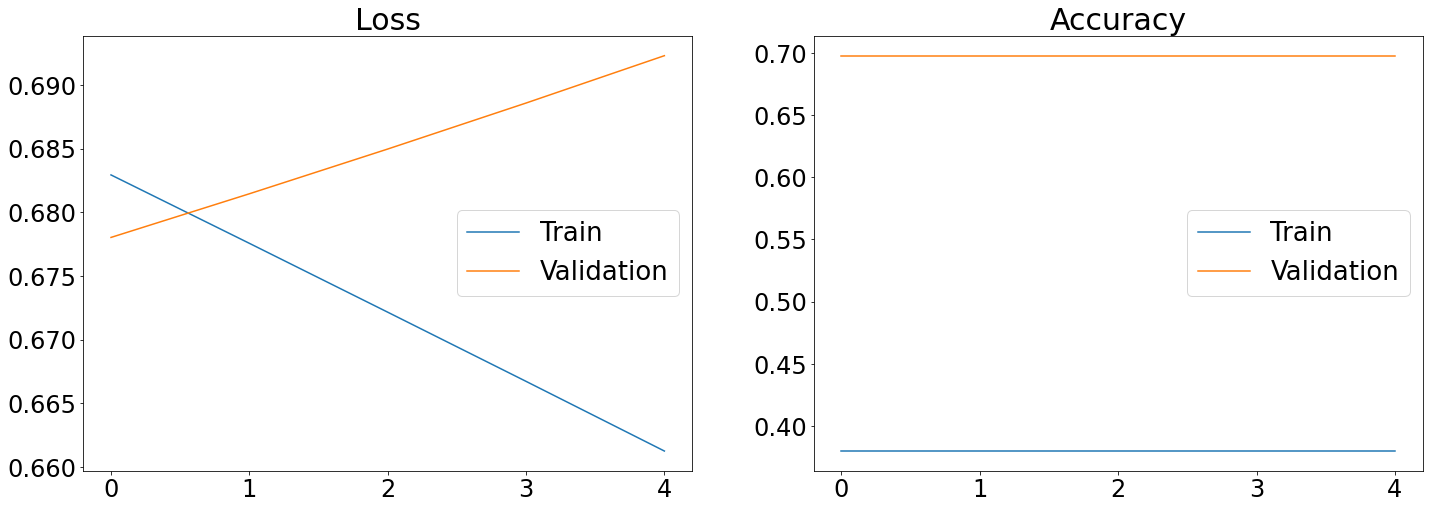

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Missing logger folder: ../logs/LSTM_100_12232021_06:39:26

  | Name          | Type    | Params
------------------------------------------
0 | model         | RNN     | 20.7 K
1 | loss_function | BCELoss | 0     
------------------------------------------
20.7 K    Trainable params
0         Non-trainable params
20.7 K    Total params
0.083     Total estimated model params size (MB)


Epoch 0:   0%|          | 0/4 [00:00<?, ?it/s]                        

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:413: UserWarning: The number of training samples (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the logging interval"


Epoch 0:  50%|█████     | 2/4 [00:01<00:01,  1.50it/s, loss=0.67, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 1:  50%|█████     | 2/4 [00:01<00:01,  1.50it/s, loss=0.67, v_num=0, val_loss=0.649, val_acc=0.884, mean_accuracy=0.884, mean_roc_auc=0.924, mean_pr_auc=0.667, train_loss=0.678, train_acc=0.480] 
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|█████     | 2/4 [00:01<00:01,  1.51it/s, loss=0.673, v_num=0, val_loss=0.652, val_acc=0.884, mean_accuracy=0.884, mean_roc_auc=0.924, mean_pr_auc=0.667, train_loss=0.673, train_acc=0.480]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|█████     | 2/4 [00:01<00:01,  1.52it/s, loss=0.672, v_num=0, val_loss=0.655, val_acc=0.884, mean_accuracy=0.884, mean_roc_auc=0.924, mean_pr_auc=0.667, train_loss=0.664, train_acc=0.500]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|█████     | 2/4 [00:01<00:01,  1.49it/s, loss=0.671, v_num=0, val_loss=0.658, val_acc=0.884, mean_accuracy=0.884, mean_roc_auc=0.924, mean_pr_auc=0.667, train_loss=0.661, train_acc

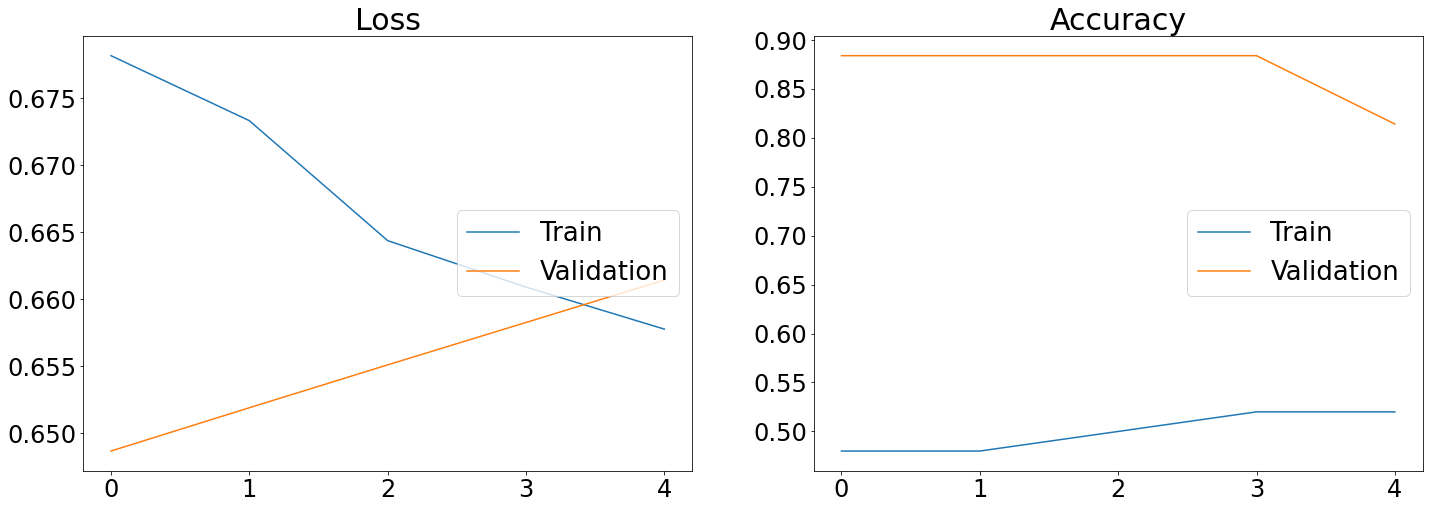

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Missing logger folder: ../logs/LSTM_100_12232021_06:39:45

  | Name          | Type    | Params
------------------------------------------
0 | model         | RNN     | 20.7 K
1 | loss_function | BCELoss | 0     
------------------------------------------
20.7 K    Trainable params
0         Non-trainable params
20.7 K    Total params
0.083     Total estimated model params size (MB)


Epoch 0:   0%|          | 0/4 [00:00<?, ?it/s]                        

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:413: UserWarning: The number of training samples (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the logging interval"


Epoch 0:  50%|█████     | 2/4 [00:01<00:01,  1.51it/s, loss=0.709, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1:  50%|█████     | 2/4 [00:01<00:01,  1.47it/s, loss=0.707, v_num=0, val_loss=0.695, val_acc=0.596, mean_accuracy=0.596, mean_roc_auc=0.456, mean_pr_auc=0.424, train_loss=0.708, train_acc=0.240]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|█████     | 2/4 [00:01<00:01,  1.54it/s, loss=0.702, v_num=0, val_loss=0.696, val_acc=0.596, mean_accuracy=0.596, mean_roc_auc=0.456, mean_pr_auc=0.424, train_loss=0.704, train_acc=0.240]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|█████     | 2/4 [00:01<00:01,  1.57it/s, loss=0.7, v_num=0, val_loss=0.698, val_acc=0.596, mean_accuracy=0.596, mean_roc_auc=0.460, mean_pr_auc=0.424, train_loss=0.701, train_acc=0.240]  
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|█████     | 2/4 [00:01<00:01,  1.50it/s, loss=0.7, v_num=0, val_loss=0.699, val_acc=0.447, mean_accuracy=0.447, mean_roc_auc=0.456, mean_pr_auc=0.424, train_loss=0.697, train_acc=0

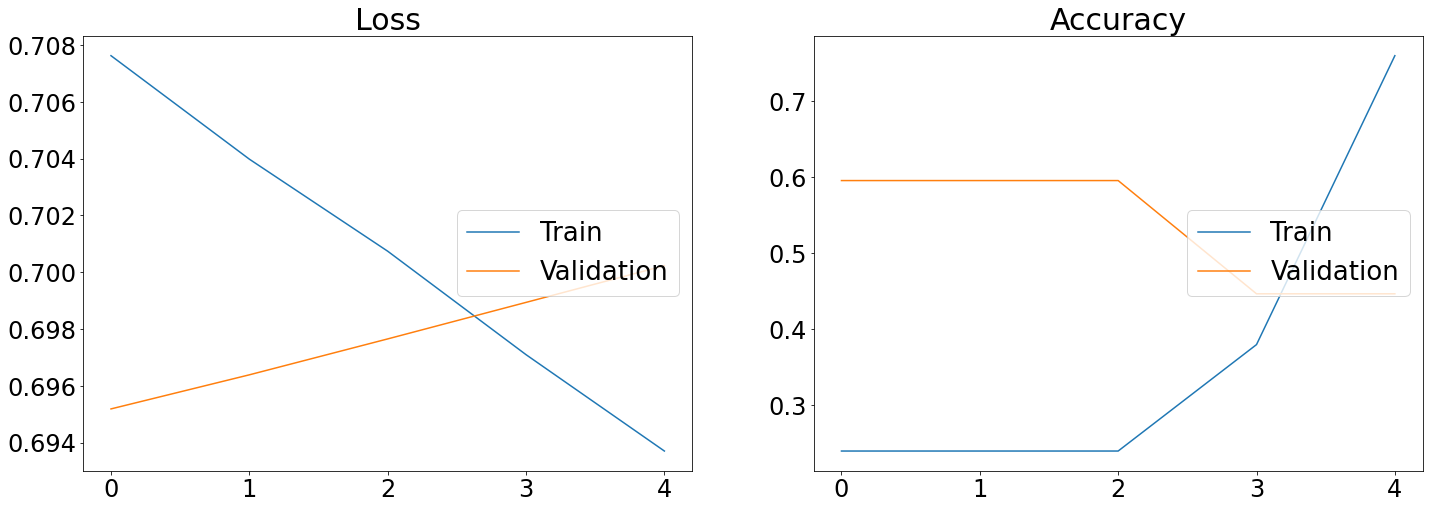

{'Accuracy': [0.72,
  0.42857142857142855,
  0.40425531914893614,
  0.2857142857142857,
  0.2826086956521739],
 'ROC AUC': [0.855263157894737,
  0.42857142857142855,
  0.2682926829268293,
  0.17302052785923755,
  0.6025641025641025],
 'PR AUC': [0.6,
  1.0000000000000002,
  0.8684963925615083,
  0.6141033313405424,
  0.631578947368421]}

In [18]:
metrics_lstm = utils.cross_validation(df_week, "LSTM", base_model, features, n_splits=N_SPLITS, epochs=EPOCHS, gpus=[0])
metrics_lstm

In [19]:
for metric_name, metric_val in metrics_lstm.items():
    print('{}: {} ± {}'.format(metric_name, np.array(metric_val).mean(), np.array(metric_val).std()))

Accuracy: 0.42422994581736484 ± 0.1594621746536709
ROC AUC: 0.46554237996326703 ± 0.24351614542044897
PR AUC: 0.7428357342540945 ± 0.16203469492106376


# RNN

In [16]:
base_model = utils.RNN(
    input_size=INPUT_SIZE,
    output_size=1,
    hidden_rnn_size=16,
    base_type="RNN"
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Missing logger folder: ../logs/RNN_100_12232021_09:38:20

  | Name          | Type    | Params
------------------------------------------
0 | model         | RNN     | 5.2 K 
1 | loss_function | BCELoss | 0     
------------------------------------------
5.2 K     Trainable params
0         Non-trainable params
5.2 K     Total params
0.021     Total estimated model params size (MB)


Epoch 0:   0%|          | 0/4 [00:00<?, ?it/s]                        

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:413: UserWarning: The number of training samples (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the logging interval"


Epoch 0:  50%|█████     | 2/4 [00:01<00:01,  1.62it/s, loss=0.502, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1:  50%|█████     | 2/4 [00:01<00:01,  1.64it/s, loss=0.495, v_num=0, val_loss=0.686, val_acc=0.574, mean_accuracy=0.574, mean_roc_auc=0.167, mean_pr_auc=0.584, train_loss=0.503, train_acc=1.000]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|█████     | 2/4 [00:01<00:01,  1.63it/s, loss=0.489, v_num=0, val_loss=0.687, val_acc=0.574, mean_accuracy=0.574, mean_roc_auc=0.167, mean_pr_auc=0.584, train_loss=0.490, train_acc=1.000]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|█████     | 2/4 [00:01<00:01,  1.66it/s, loss=0.483, v_num=0, val_loss=0.688, val_acc=0.574, mean_accuracy=0.574, mean_roc_auc=0.167, mean_pr_auc=0.584, train_loss=0.478, train_acc=1.000]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|█████     | 2/4 [00:01<00:01,  1.69it/s, loss=0.477, v_num=0, val_loss=0.690, val_acc=0.574, mean_accuracy=0.574, mean_roc_auc=0.176, mean_pr_auc=0.597, train_loss=0.466, train_acc

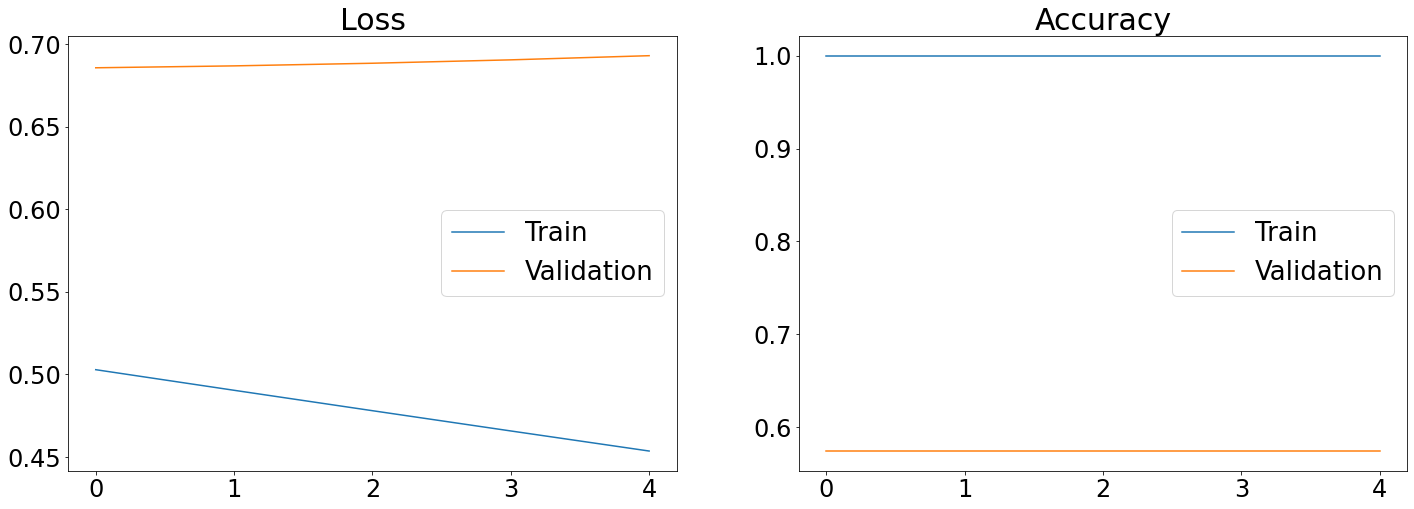

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Missing logger folder: ../logs/RNN_100_12232021_09:39:26

  | Name          | Type    | Params
------------------------------------------
0 | model         | RNN     | 5.2 K 
1 | loss_function | BCELoss | 0     
------------------------------------------
5.2 K     Trainable params
0         Non-trainable params
5.2 K     Total params
0.021     Total estimated model params size (MB)


Epoch 0:   0%|          | 0/4 [00:00<?, ?it/s]                        

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:413: UserWarning: The number of training samples (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the logging interval"


Epoch 0:  50%|█████     | 2/4 [00:01<00:01,  1.52it/s, loss=0.468, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.468, v_num=0, val_loss=0.904, val_acc=0.233, mean_accuracy=0.233, mean_roc_auc=0.715, mean_pr_auc=0.392, train_loss=0.467, train_acc=0.960]        

RuntimeError: DataLoader worker (pid(s) 50460) exited unexpectedly

In [17]:
metrics_rnn = utils.cross_validation(df_week, "RNN", base_model, features, n_splits=N_SPLITS, epochs=EPOCHS, gpus=[0])
metrics_rnn

In [ ]:
for metric_name, metric_val in metrics_rnn.items():
    print('{}: {} ± {}'.format(metric_name, np.array(metric_val).mean(), np.array(metric_val).std()))

Epoch 1:   0%|          | 0/4 [00:17<?, ?it/s, loss=0.468, v_num=0, val_loss=0.904, val_acc=0.233, mean_accuracy=0.233, mean_roc_auc=0.715, mean_pr_auc=0.392, train_loss=0.467, train_acc=0.960]